In [39]:
import sklearn
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt

In [40]:
ls -l "C:/Users/sora4/Python Code/Neural_Network_forward_and_back/"

 Volume in drive C has no label.
 Volume Serial Number is 8EAE-8C16

 Directory of C:\Users\sora4\Python Code\Neural_Network_forward_and_back


 Directory of C:\Users\sora4\Python Code\Neural_Network_forward_and_back

07/22/2018  03:39 PM    <DIR>          .
07/22/2018  03:39 PM    <DIR>          ..
07/08/2018  12:53 PM    <DIR>          .idea
07/08/2018  06:15 PM    <DIR>          .ipynb_checkpoints
06/17/2014  08:37 PM           392,564 ex4.pdf
06/17/2014  08:37 PM         7,511,764 ex4data1.mat
06/17/2014  08:37 PM            79,592 ex4weights.mat
06/17/2014  08:37 PM               268 ml_login_data.mat
07/22/2018  03:39 PM            82,177 Neural Networks.ipynb
07/08/2018  09:28 PM                24 README.md
               6 File(s)      8,066,389 bytes
               4 Dir(s)  311,508,918,272 bytes free


In [46]:
data = io.loadmat("ex4data1.mat")
X = data["X"]
y = data["y"]
print(X.shape)

(5000, 400)


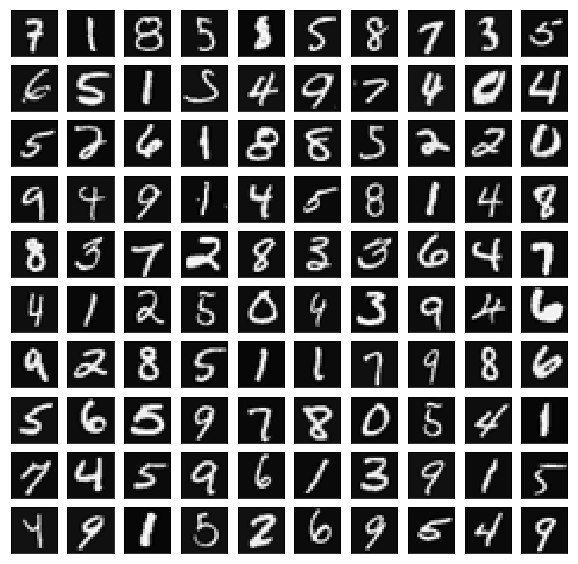

In [47]:
def plot_data():
    sample = np.random.choice(range(0, X.shape[0]), size= 100).flatten()
    fig, axes = plt.subplots(10, 10, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(np.reshape(X[sample[i], :], (20, 20)).T, cmap="gray")
        ax.set(xticks=[], yticks=[])
plot_data()

In [48]:
def add_ones_column_to_X(X):
    new_X = np.ones((X.shape[0], X.shape[1] + 1))
    new_X[:, 1:] = X
    return new_X
X_ready = add_ones_column_to_X(X)
X_ready.shape

(5000, 401)

In [49]:
ex4_weights = io.loadmat("ex4weights.mat")
theta1_pre = ex4_weights["Theta1"]
theta2_pre = ex4_weights["Theta2"]
theta1_pre.shape

(25, 401)

In [54]:
y_new = y.copy()
y_new[y.flatten() == 10] = 0
y

array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=uint8)

In [75]:
def transform_y_to_dummy_columns(y):
    # Can change this to deal with the matlab has no 0 vals and the y-value is 10
    y_true_vals = np.zeros((y.shape[0], np.max(y)))
    for i in range(0, y.shape[0]):
        y_true_vals[i, y[i] - 1] = 1
    return y_true_vals

In [78]:
from scipy.special import expit
def h(thetas_ls, X):
    """
    Theta will be a list of arrays,
    each array will be another theta
    for the system.
    """ 
    # First layers activation is X
    activation_vals = X.T
    
    for theta in thetas_ls:
        activation_vals = add_ones_column_to_X(activation_vals.T).T
        z = np.dot(theta, activation_vals)
        activation_vals = expit(z)
    return activation_vals.T
        
def nnCostFunction(theta_ls, X, y):
    number_of_output_nodes = np.max(y)
    y_dum = transform_y_to_dummy_columns(y)
    J = 0.0
    h_theta = h(theta_ls, X)
    for k in range(0, number_of_output_nodes):
        first_term = -y_dum[:, k]*np.log(h_theta[:, k])
        second_term = - (1 - y_dum[:, k])*np.log(1 - h_theta[:, k])
        J +=first_term + second_term
    m = X.shape[0]
    return np.sum(J)/m
theta_whole = [theta1_pre, theta2_pre]
h(theta_whole, X)

nnCostFunction(theta_whole, X, y)


0.2876291651613189

In [90]:
def nnCostRegularizationFunction(theta_ls, X, y, lambda_val=1):
    number_of_output_nodes = np.max(y)
    y_dum = transform_y_to_dummy_columns(y)
    J = 0.0
    h_theta = h(theta_ls, X)
    for k in range(0, number_of_output_nodes):
        first_term = -y_dum[:, k]*np.log(h_theta[:, k])
        second_term = - (1 - y_dum[:, k])*np.log(1 - h_theta[:, k])
        J +=first_term + second_term
        
    m = X.shape[0]
    J = np.sum(J)/m
    # For regularization
    for theta in theta_ls:
        J += lambda_val*np.sum(theta[:,1:]**2)/(2*m)
    return J

nnCostRegularizationFunction(theta_whole, X, y)

0.38376985909092365